In [53]:
import cv2 as cv
import numpy as np
import tarfile
import skimage
import os
from PIL import Image
from skimage import filters
from skimage import morphology
from scipy import ndimage as ndi
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage import exposure
from skimage.exposure import histogram, cumulative_distribution, equalize_hist, match_histograms, is_low_contrast
from skimage import color
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import imutils
from scipy.spatial import distance as dist
from collections import OrderedDict
import copy
import PIL.Image

In [54]:
from others.imAugment import *

In [55]:
def plotMultipleImages(nrows, ncols, images, titles, cmap, size=(20,20)):
    fig = plt.figure(figsize=(size[0],size[1]))
    fig.subplots_adjust(hspace=0.2, wspace=0.3)
    for i in range(len(titles)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        if cmap[i]=='rgb':
            ax.imshow(images[i])
        else:
            ax.imshow(images[i], cmap=cmap[i])
        ax.set_title(titles[i])
    plt.show()
    
def plot_single(im, cmap='rgb'):
    fig, ax = plt.subplots(figsize=(13, 13))
    if cmap=='rgb':
        ax.imshow(im)
    else:
        ax.imshow(im, cmap=cmap)
    ax.axis('on')
    plt.show()
    
def enhance_im(rgb_in_im, alpha=1, beta=0):
    #new_im = np.zeros(old_im.shape, old_im.dtype)
    hsv_in_im = cv.cvtColor(rgb_in_im, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_in_im)
    v = cv.convertScaleAbs(v, alpha=alpha, beta=beta)
    hsv_out_im = cv.merge((h,s,v))
    rgb_out_im = cv.cvtColor(hsv_out_im, cv.COLOR_HSV2RGB)
    
    return rgb_out_im.astype(np.uint8)

In [56]:
def load_img(path):
    img_dict = {}
    for file in os.listdir(path):
        if file.endswith('.jpg'):
            img_dict[int(file.split('.jpg')[0].split('_')[1])] = PIL.Image.open(os.path.join(path, file)) # size = (H=4000, W=6000), mode = RGB
    return img_dict 
train_images = load_img(os.path.join("data", "train"))

# dict_keys([17, 1, 3, 7, 14, 24, 10, 2, 15, 11, 23, 18, 9, 13, 12, 21, 5, 22, 20, 27, 19, 8, 16, 25, 26, 6, 0, 4])
# image 1 gives the best view, we take it as the reference
ref_img = np.array(train_images[0])

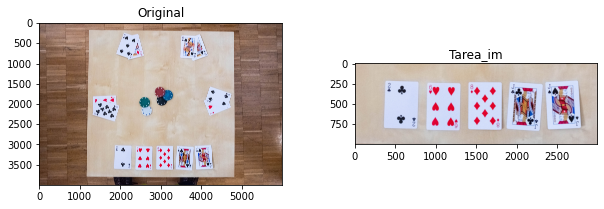

In [57]:
Tarea_im = ref_img[2800:3800, 1500:4500]
plotMultipleImages(1, 2, [ref_img, Tarea_im], ['Original', 'Tarea_im'], ['rgb']*2, (10, 10)) 

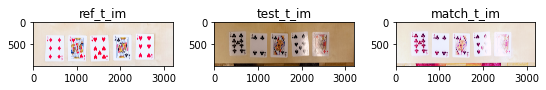

In [58]:
ref_img = np.array(train_images[3])
ref_t_im = ref_img[2800:3800, 1500:4700]
test_img = np.array(train_images[8])
test_t_im = test_img[2800:3800, 1500:4700]
match_t_im = match_histograms(test_t_im, ref_t_im, multichannel=True).astype(np.uint8)
plotMultipleImages(1, 3, [ref_t_im, test_t_im, match_t_im], ['ref_t_im', 'test_t_im', 'match_t_im'], ['rgb']*3, (15, 15)) 

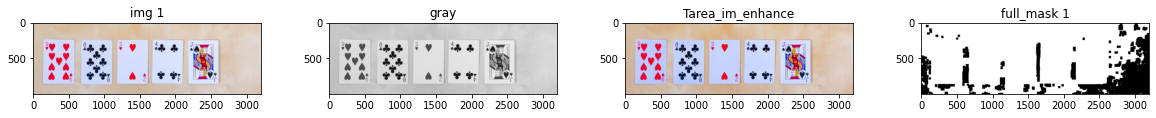

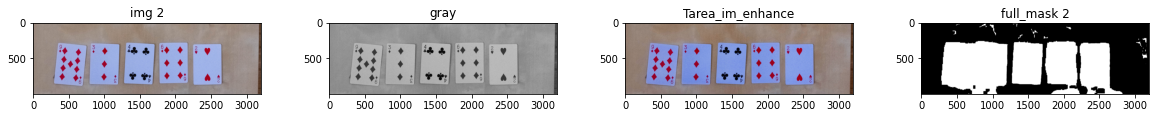

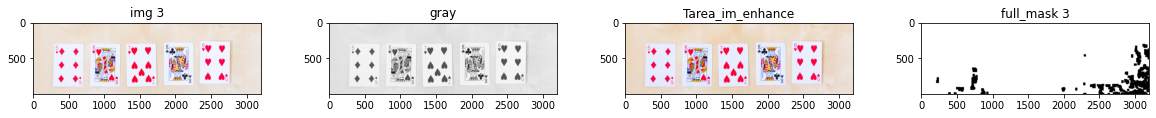

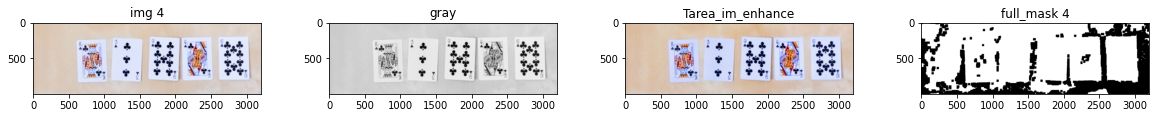

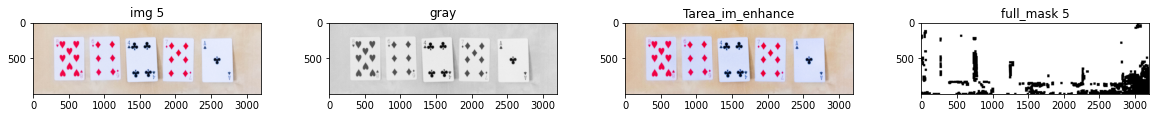

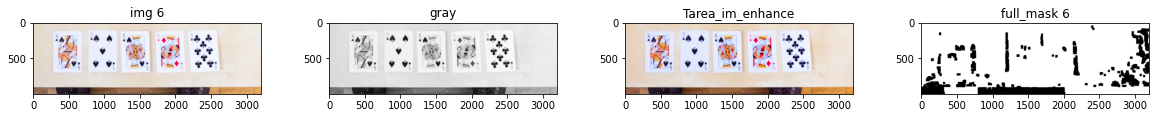

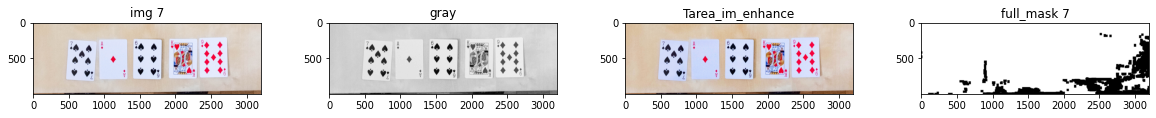

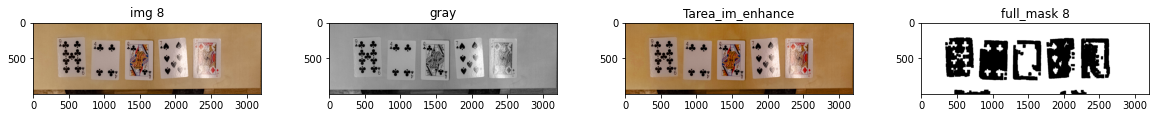

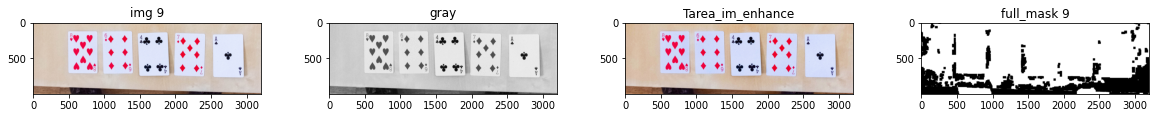

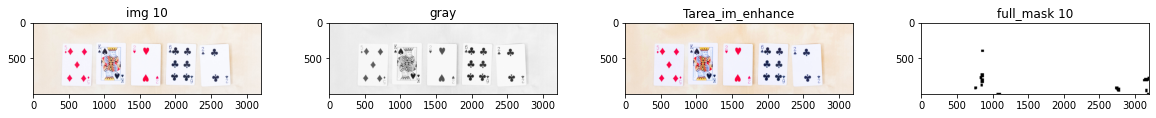

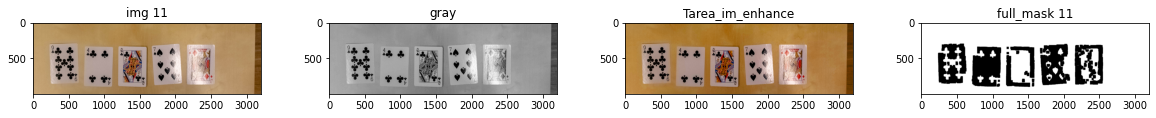

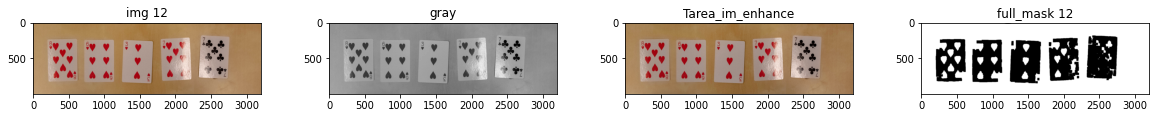

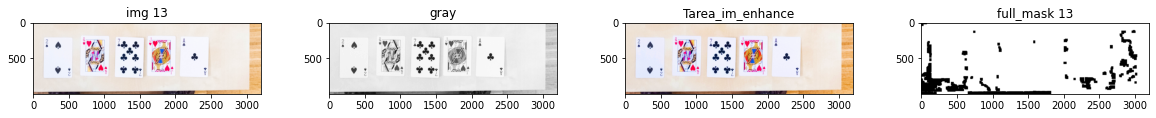

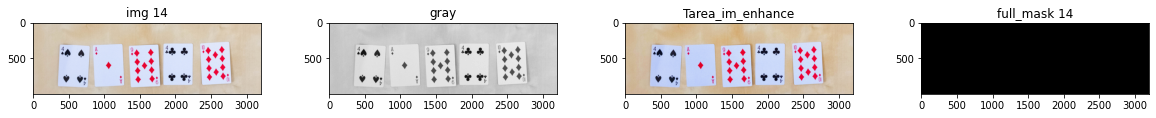

In [59]:
for img_ID in range(1, 15):
    ori_test_img = np.array(train_images[img_ID])
    Tarea_im = ori_test_img[2800:3800, 1500:4700]
    
    gray = cv.cvtColor(Tarea_im, cv.COLOR_RGB2GRAY)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)
    
    Tarea_im_enhance = img_enhance(Tarea_im)
    
    image = cv.cvtColor(Tarea_im_enhance, cv.COLOR_RGB2HLS)

    lower1 = np.array([15, 0, 0])
    upper1 = np.array([180, 255, 255])
    lower_mask = cv.inRange(image, lower1, upper1)
    full_mask = lower_mask;
    kernelClose = np.ones((15,15),np.uint8)
    full_mask = cv.morphologyEx(full_mask, cv.MORPH_CLOSE, kernelClose, iterations=2)

    plotMultipleImages(1, 4, [Tarea_im, gray, Tarea_im_enhance, full_mask], \
                           ['img {}'.format(img_ID), 'gray', 'Tarea_im_enhance', 'full_mask {}'.format(img_ID)],\
                           ['rgb', 'gray', 'rgb', 'gray'], (20,20))
    

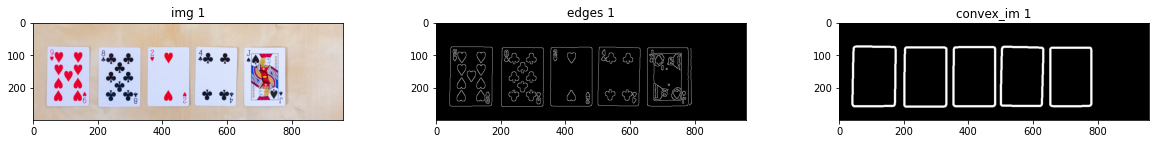

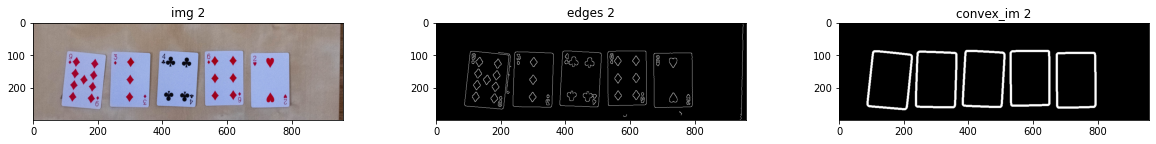

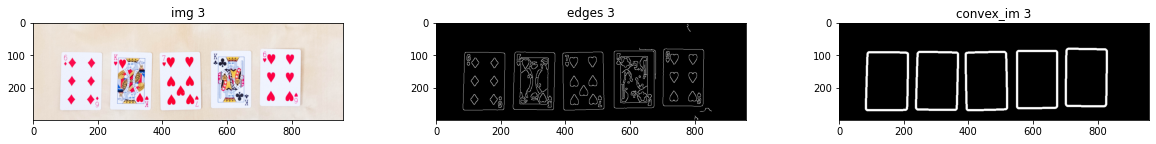

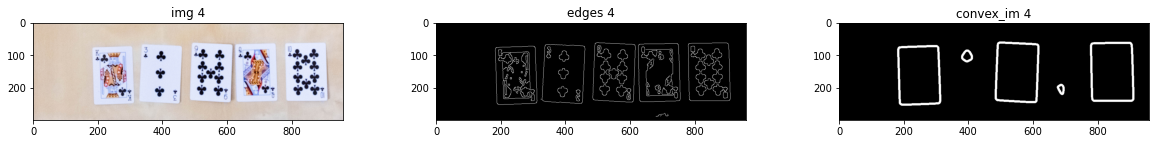

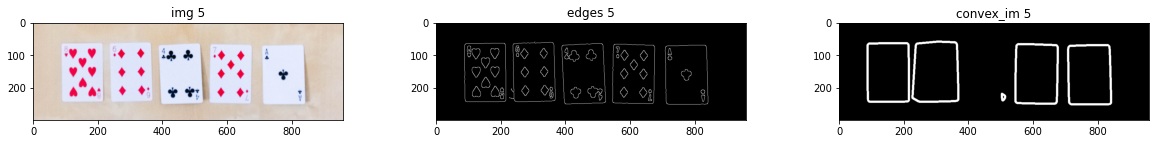

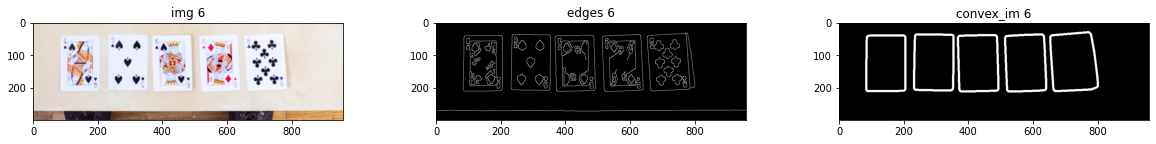

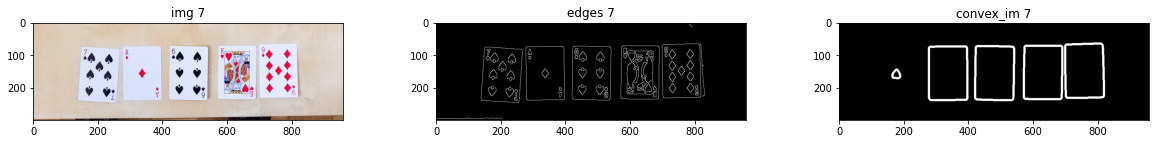

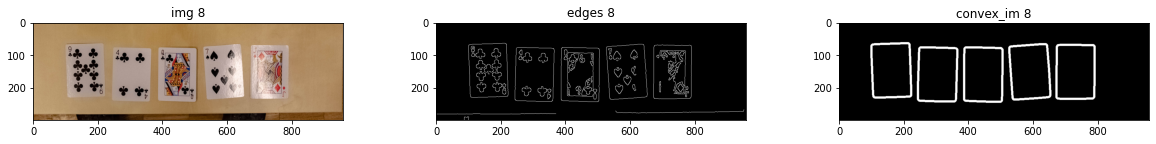

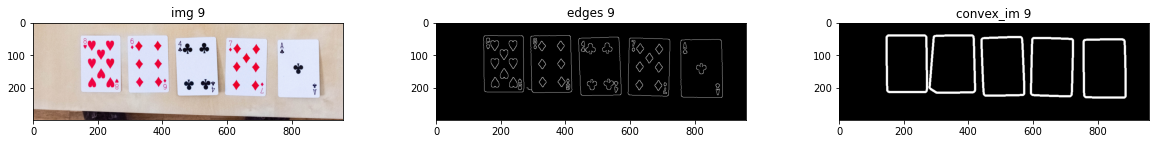

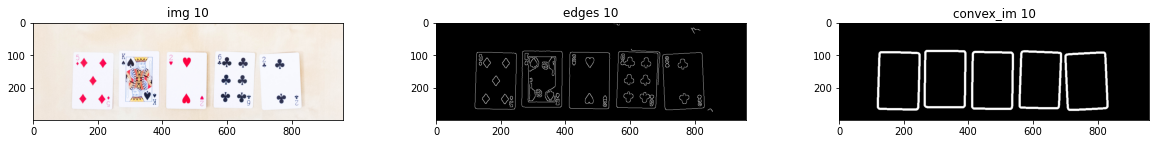

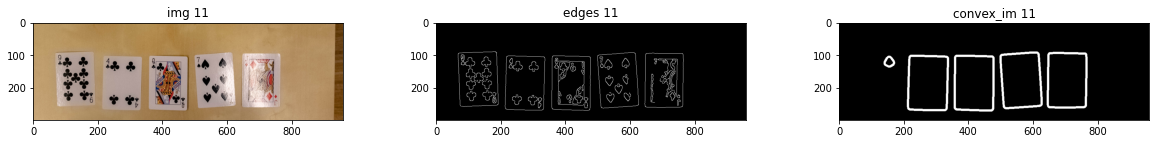

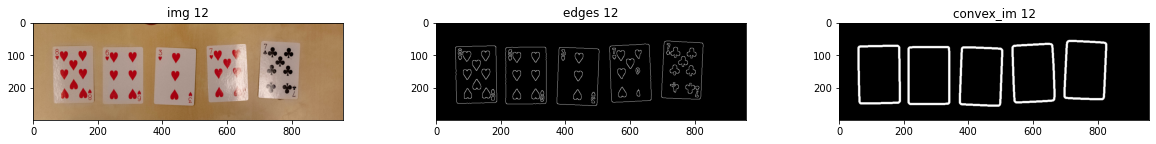

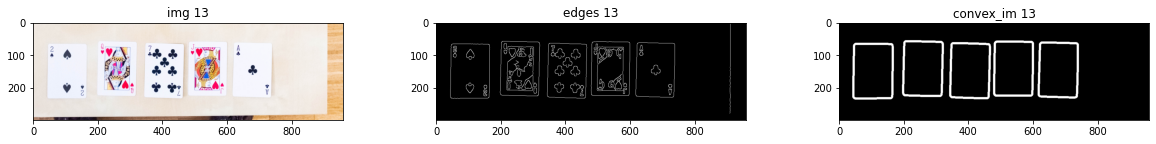

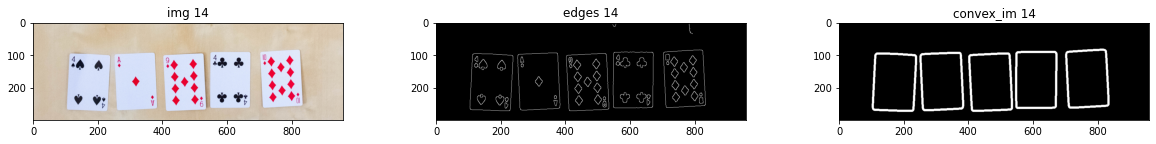

In [80]:
for img_ID in range(1, 15):
    ori_test_img = np.array(train_images[img_ID])
    Tarea_im = ori_test_img[2800:3800, 1500:4700]
    
    scale_precent =30
    width = int(Tarea_im.shape[1] * scale_precent/100)
    height = int(Tarea_im.shape[0] * scale_precent/100)
    dim = (width, height)
    img = cv.resize(Tarea_im, dim, interpolation=cv.INTER_AREA)

    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    dst = cv.equalizeHist(gray)
    gaussian = cv.GaussianBlur(dst, (9, 9), 0)
        
    threshold1 = 255
    threshold2 = 50
    edges = cv.Canny(gaussian, threshold1, threshold2)
    
    h, w, ch = img.shape
    contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea,reverse=True)[:5]  
    convex_im = np.zeros((h, w, ch), dtype=np.uint8)

    for contour in contours:
        convexHull = cv.convexHull(contour)
        cv.drawContours(convex_im, [convexHull], -1, (255, 255, 255), 5)

    plotMultipleImages(1, 3, [img, edges, convex_im], \
                           ['img {}'.format(img_ID), 'edges {}'.format(img_ID), 'convex_im {}'.format(img_ID)],\
                           ['rgb', 'gray', 'gray'], (20,20))
    

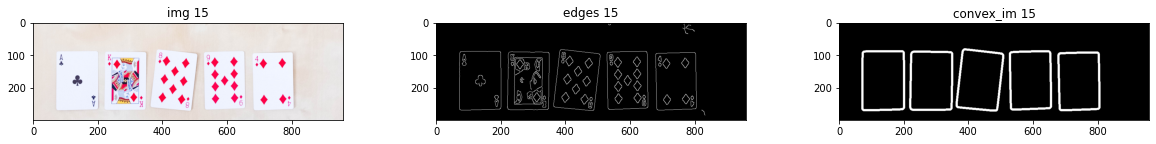

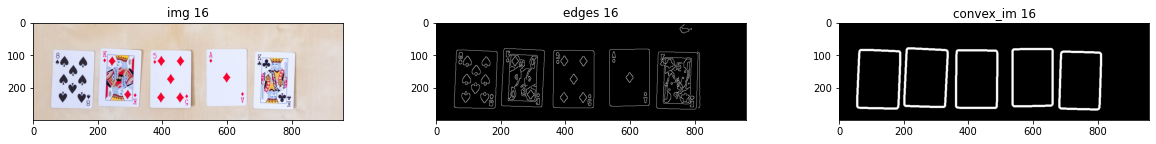

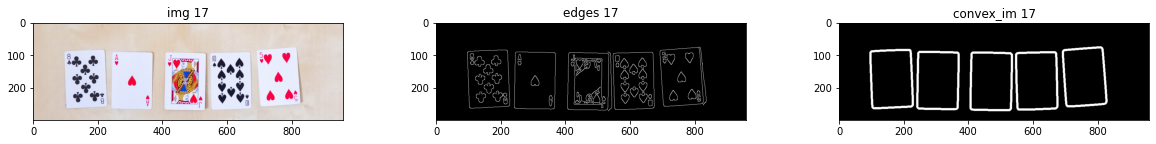

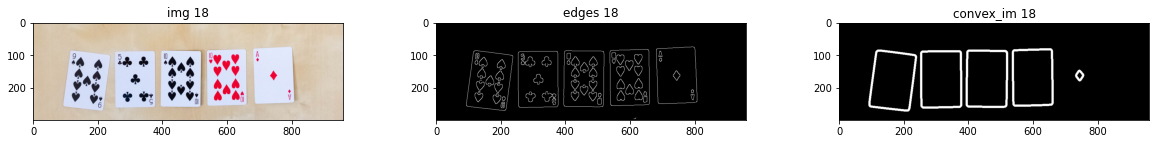

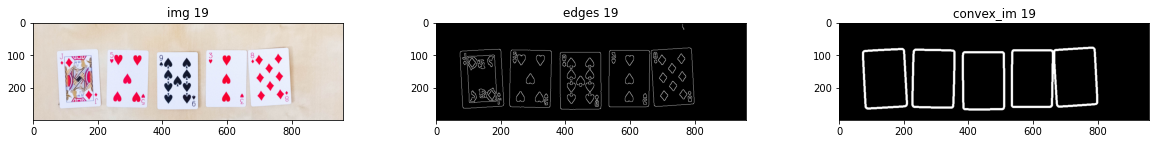

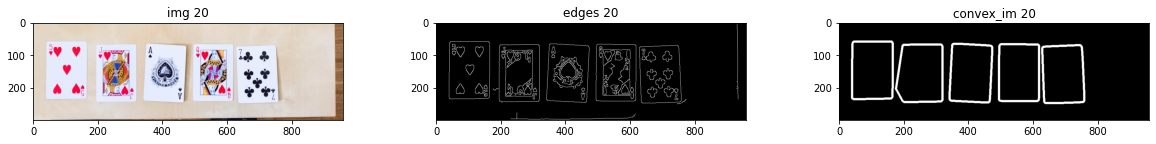

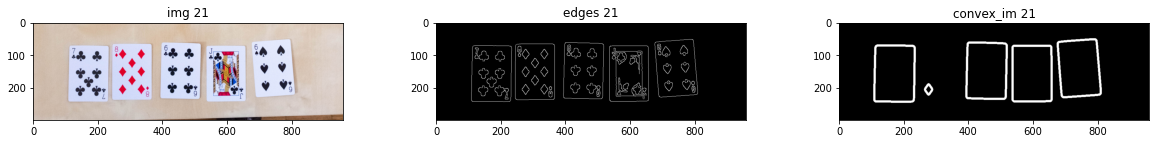

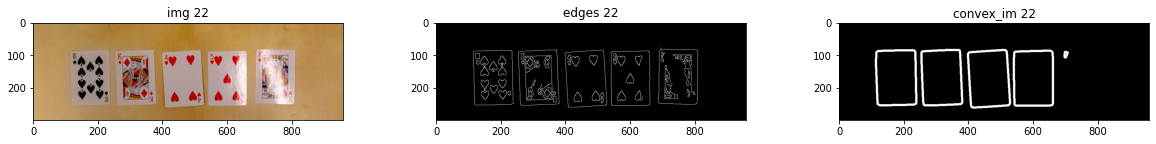

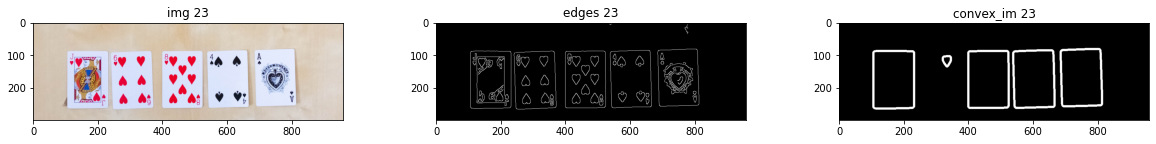

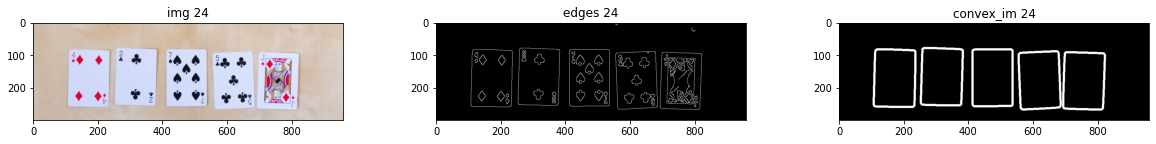

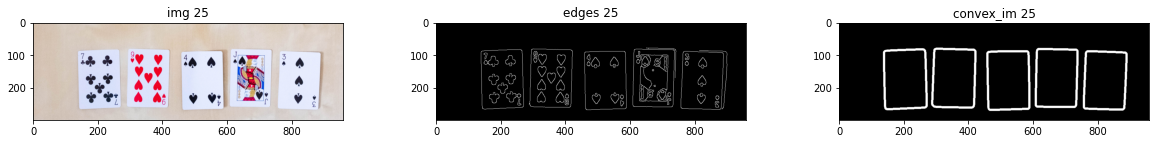

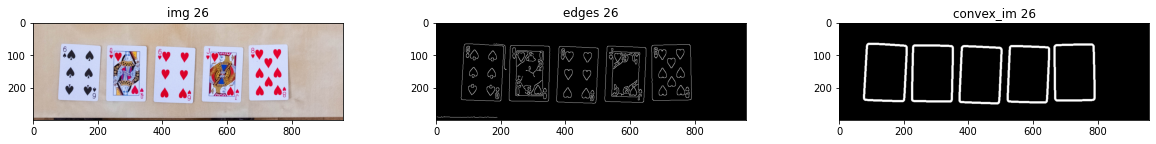

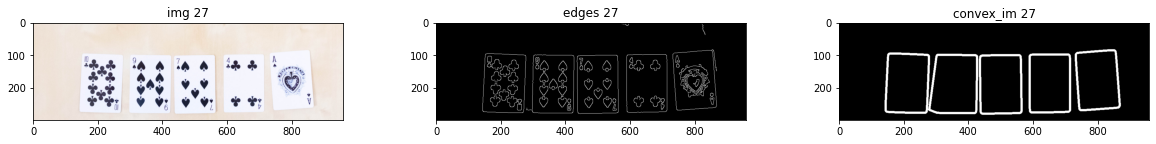

In [78]:
for img_ID in range(15, 28):
    ori_test_img = np.array(train_images[img_ID])
    Tarea_im = ori_test_img[2800:3800, 1500:4700]
    
    scale_precent =30
    width = int(Tarea_im.shape[1] * scale_precent/100)
    height = int(Tarea_im.shape[0] * scale_precent/100)
    dim = (width, height)
    img = cv.resize(Tarea_im, dim, interpolation=cv.INTER_AREA)

    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    dst = cv.equalizeHist(gray)
    gaussian = cv.GaussianBlur(dst, (9, 9), 0)
        
    threshold1 = 255
    threshold2 = 50
    edges = cv.Canny(gaussian, threshold1, threshold2)
    
    h, w, ch = img.shape
    contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea,reverse=True)[:5]  
    convex_im = np.zeros((h, w, ch), dtype=np.uint8)

    for contour in contours:
        convexHull = cv.convexHull(contour)
        cv.drawContours(convex_im, [convexHull], -1, (255, 255, 255), 5)

    plotMultipleImages(1, 3, [img, edges, convex_im], \
                           ['img {}'.format(img_ID), 'edges {}'.format(img_ID), 'convex_im {}'.format(img_ID)],\
                           ['rgb', 'gray', 'gray'], (20,20))
    

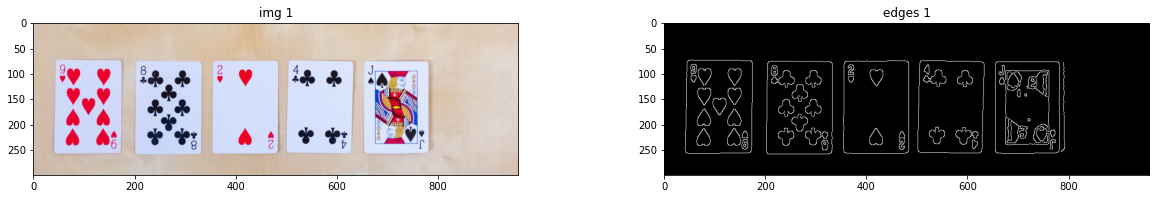

In [73]:
img_ID = 1
ori_test_img = np.array(train_images[img_ID])
Tarea_im = ori_test_img[2800:3800, 1500:4700]

scale_precent =30
width = int(Tarea_im.shape[1] * scale_precent/100)
height = int(Tarea_im.shape[0] * scale_precent/100)
dim = (width, height)
img = cv.resize(Tarea_im, dim, interpolation=cv.INTER_AREA)

gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
dst = cv.equalizeHist(gray)
gaussian = cv.GaussianBlur(dst, (9, 9), 0)

threshold1 = 255
threshold2 = 50
edges = cv.Canny(gaussian, threshold1, threshold2)
plotMultipleImages(1, 2, [img, edges], \
                           ['img {}'.format(img_ID), 'edges {}'.format(img_ID)],\
                           ['rgb', 'gray'], (20,20))

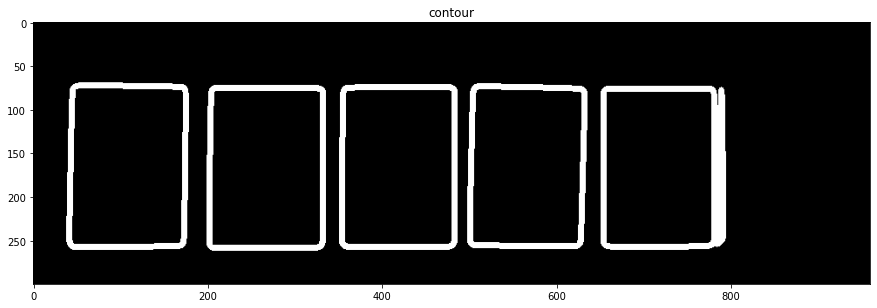

In [76]:
h, w, ch = img.shape
contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
obj_img = np.zeros((h, w, ch), dtype=np.uint8)
#c = max(contours, key = cv.contourArea)
for contour in contours:
    convexHull = cv.convexHull(contour)
    cv.drawContours(obj_img, [convexHull], -1, (255, 255, 255), 5)

#cv.drawContours(obj_img, c, -1, [255,255,255], thickness=5)
plotMultipleImages(1, 1, [obj_img], ['contour'], ['gray'], (15, 15)) 